In [1]:
#@title Font Install for plots
# !sudo ACCEPT_EULA=Y apt -y install msttcorefonts -qq
# !rm ~/.cache/matplotlib -rf

## Optimization of Force constants for DFT lattice constant

In [2]:
#@title Imports and utility code
!pip install -q uv
!uv pip install -q --system git+https://www.github.com/google/jax-md
!uv pip install -q --system git+https://github.com/phonopy/phonopy
!uv pip install -q --system seekpath

from jax import config
config.update('jax_enable_x64', True)

from typing import Callable, Tuple, TextIO, Dict, Any, Optional
import jax.numpy as jnp
import numpy as onp

from jax import jit
from jax import grad
from jax import vmap
from jax import random
from jax import lax
from functools import wraps, partial
from jax import checkpoint, value_and_grad
from jax import jacfwd, jacrev, linearize
from jax import hessian
from jax_md import space
from jax_md import minimize
from jax_md import simulate
from jax_md import energy
from jax_md import partition
from jax_md import quantity, util, smap
from jax_md.util import f32, f64
from jax_md.colab_tools import renderer
from jax.scipy.optimize import minimize as jax_min
from scipy.optimize import minimize as scipy_min

import time
import pickle
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from functools import partial
import pandas as pd

# Phonopy
import phonopy
from phonopy.units import PwscfToTHz
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc({'text.usetex' : False,
                     'font.size': 14,
                     'font.family': 'Arial',
                     # 'mathtext.fontset': 'cm',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': 'Arial',
                     'mathtext.it': 'Arial:italic',
                     'mathtext.bf': 'Arial:bold',
                    })
# Bandpath labels
labels = ["$\\Gamma$", "X", "W", "K", "$\\Gamma$", "L", "U"]

def plot_band_path_lines():
  plt.axvline(x=0.18412820, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.axvline(x=0.27619220, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.axvline(x=0.34129140, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.axvline(x=0.53658880, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.axvline(x=0.69604840, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.axvline(x=0.80880340, ymin=-1, ymax=20,ls="--",c='b', lw=2)
  plt.xticks([0.0,0.18412820,0.27619220,0.34129140,0.53658880,0.69604840,0.80880340],labels)

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int):
    copies = (copies,) * d

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...]
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1]
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]

  return onp.concatenate(Rs)

def pos_lattice(cord_frac,latvec,N_multiply):
  """
  Constructs supercell
  Args:
    cord_frac: Fractional co-ordinates (primitive/unit cell)
    latvec: Lattice vector (primitive/unit cell)
    N_replica: Number of replicas in 3 directions
  Returns:
    supercell co-ordinates and lattice vector
  """
  rows = cord_frac.split('\n')
  rows = jnp.array([list(map(float,r.split(' ')[:3])) for r in rows])
  R_supercell = lattice(rows, N_multiply, latvec)
  latvec_supercell = latvec * N_multiply
  R_supercell = jnp.array(R_supercell, f64)
  return R_supercell, latvec_supercell

def hessian_fc(hessian,filename):
  """
  Function to store the force constants in phonopy FORCE_CONSTANTS format.

  Args:
    hessian: Reshaped hessian (3Nx3N)
    filename: Output file name.
  Returns:
    FORCE_CONSTANTS file for phonopy to read.
  """
  fc_file = open(filename, "a")
  fc_file.write("  {:d}   {:d}\n".format(int(hessian.shape[0]/3),int(hessian.shape[0]/3)))
  for i in range(int(hessian.shape[0]/3)):
    for j in range(int(hessian.shape[0]/3)):
      fc_file.write("{:d} {:d}\n".format(i+1,j+1))
      H_part = hessian[i*3:(i+1)*3,j*3:(j+1)*3]
      fc_file.write("{:22.15f}{:22.15f}{:22.15f}\n".format(H_part[0][0],H_part[0][1],H_part[0][2]))
      fc_file.write("{:22.15f}{:22.15f}{:22.15f}\n".format(H_part[1][0],H_part[1][1],H_part[1][2]))
      fc_file.write("{:22.15f}{:22.15f}{:22.15f}\n".format(H_part[2][0],H_part[2][1],H_part[2][2]))
  fc_file.close()
  return print("File exported to FC format")

def jax_md_to_qe_cord_format(filename, alpha, latvec, R, species, mass):
  """
  Function to store the co-ordinates to quantum espresso format.

  Args:
    alpha: Cell matrix scaling factor
    latvec: Cell matrix
    R: scaled co-ordinates
    species: Atomic species
    mass: Atomic mass
    filename: Output file name.
  Returns:
    co-ordinate file for quantum espresso.
  """
  latvec_new = alpha*latvec
  qe_file = open(filename, "a")
  qe_file.write("CELL_PARAMETERS angstrom\n")
  qe_file.write("{:5.12f} {:5.12f} {:5.12f}\n".format(latvec_new[0][0],latvec_new[0][1],latvec_new[0][2]))
  qe_file.write("{:5.12f} {:5.12f} {:5.12f}\n".format(latvec_new[1][0],latvec_new[1][1],latvec_new[1][2]))
  qe_file.write("{:5.12f} {:5.12f} {:5.12f}\n".format(latvec_new[2][0],latvec_new[2][1],latvec_new[2][2]))
  qe_file.write("ATOMIC_POSITIONS crystal\n")
  for i in range(R.shape[0]):
    qe_file.write("{:s} {:5.12f} {:5.12f} {:5.12f}\n".format('Si', R[i][0], R[i][1], R[i][2]))
  qe_file.close()
  return print("File exported to QE format")

def jax_md_to_lammps_cord_format(filename, alpha, latvec, R, species, mass):
  """Function to store the co-ordinates to LAMMPS format.

  Args:
    alpha: Cell matrix scaling factor
    latvec: Cell matrix
    R: scaled co-ordinates
    species: Atomic species
    mass: Atomic mass
    filename: Output file name.
  Returns:
    co-ordinate file for LAMMPS.
  """
  latvec_new = alpha*latvec
  lammps_file = open(filename, "a")
  lammps_file.write("Generated using JAX MD \n")
  lammps_file.write("\n")
  lammps_file.write("{:d} atoms \n".format(R.shape[0]))
  lammps_file.write("\n")
  lammps_file.write("{:d} atom types \n".format(species))
  lammps_file.write("\n")
  lammps_file.write("0.00000000 {:5.8f} xlo xhi \n".format(latvec_new[0][0]))
  lammps_file.write("0.00000000 {:5.8f} ylo yhi \n".format(latvec_new[1][1]))
  lammps_file.write("0.00000000 {:5.8f} zlo zhi \n".format(latvec_new[2][2]))
  lammps_file.write("0.00000000 0.00000000 0.00000000 xy xz yz \n")
  lammps_file.write("\n")
  lammps_file.write("Masses \n")
  lammps_file.write("\n")
  lammps_file.write("{:d} {:5.8f} \n".format(species,mass))
  lammps_file.write("\n")
  lammps_file.write("Atoms \n")
  lammps_file.write("\n")
  R = jnp.matmul(R,latvec_new)
  for i in range(R.shape[0]):
    lammps_file.write("{:d} {:d} {:5.10f} {:5.10f} {:5.10f}\n".format(i + 1, species, R[i][0], R[i][1], R[i][2]))
  lammps_file.close()
  return print("File exported to lammps format")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 85.4 MB/s eta 0:00:00


In [3]:
# Download force constant files
!wget -q https://raw.githubusercontent.com/M3RG-IITD/Force-field-optimization/main/Si_FF/Si_SW_FC/FORCE_CONSTANTS_LAMMPS
!wget -q https://raw.githubusercontent.com/M3RG-IITD/Force-field-optimization/Si_DFT/Si_VASP_DFT_FC/FORCE_CONSTANTS_VASP

In [4]:
# Silicon conventional cell atomic position.
si_text_dia_con = """0.250000 0.750000 0.250000 Si
0.000000 0.000000 0.500000 Si
0.250000 0.250000 0.750000 Si
0.000000 0.500000 0.000000 Si
0.750000 0.750000 0.750000 Si
0.500000 0.000000 0.000000 Si
0.750000 0.250000 0.250000 Si
0.500000 0.500000 0.500000 Si"""

# Lattice constant for SW
latvec_dia_con = jnp.array([[5.431, 0.000000, 0.000000], [0.00000, 5.431, 0.00000],[0.00000, 0.0000, 5.431]])

# Positions and lattice vectors
R_con_dia, l_con_dia = pos_lattice(si_text_dia_con, latvec_dia_con, 1)

## Phonopy

In [5]:
# We construct the supercell using Phonopy
unitcell = phonopy.structure.atoms.PhonopyAtoms(symbols=['Si'] * 8,
                        cell=l_con_dia, # Lattice vector
                        scaled_positions=R_con_dia) # Scaled co-ordinates of super-cell

phonon = phonopy.Phonopy(unitcell,
                 supercell_matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                  primitive_matrix=[[0, 0.5, 0.5],
                                   [0.5, 0, 0.5],
                                   [0.5, 0.5, 0]])
phonon.save()

'phonopy_params.yaml'

In [6]:
# Silicon primitive cell with 2 atoms
print(phonon.primitive)

lattice:
- [     0.000000000000000,     2.715500000000000,     2.715500000000000 ] # a
- [     2.715500000000000,     0.000000000000000,     2.715500000000000 ] # b
- [     2.715500000000000,     2.715500000000000,     0.000000000000000 ] # c
points:
- symbol: Si # 1
  coordinates: [  0.750000000000000,  0.750000000000000,  0.750000000000000 ]
  mass: 28.085500
- symbol: Si # 2
  coordinates: [  0.500000000000000,  0.500000000000000,  0.500000000000000 ]
  mass: 28.085500


In [7]:
# Generate super cell
R_s, l_s = phonon.supercell.scaled_positions, phonon.supercell.cell
R_s_dia, l_s_dia = jnp.array(R_s, f64), jnp.array(l_s, f64)

In [8]:
displacement_dia, shift_dia = space.periodic_general(l_s_dia)
dist_fun_dia = space.metric(displacement_dia)
neighbor_fn_dia_SW, energy_fn_dia_SW = energy.stillinger_weber_neighbor_list(displacement_dia, l_s_dia)
nbrs_dia_SW = neighbor_fn_dia_SW.allocate(R_s_dia)
energy_fn_exact =  energy.stillinger_weber(displacement_dia)
print("Number of atoms in supercell = {}".format(R_s_dia.shape[0]))

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Number of atoms in supercell = 64


In [9]:
# We compute the the Hessian here
def hessian_linearized(energy_fn, R, **kwargs):
  U_R = jit(partial(energy_fn, **kwargs))
  _, hvp = linearize(grad(U_R), R)
  hvp = jit(hvp)
  basis = jnp.eye(R.shape[0]*R.shape[1]).reshape(-1, *R.shape)
  return jnp.stack([hvp(e) for e in basis]).reshape(R.shape + R.shape)

H = hessian_linearized(energy_fn_dia_SW,R=jnp.array(R_s_dia),neighbor=nbrs_dia_SW)

In [10]:
H = hessian_linearized(energy_fn_exact,R=jnp.array(R_s_dia))
H_reshaped = H.swapaxes(1,2).reshape(3*R_s_dia.shape[0],3*R_s_dia.shape[0])

In [11]:
phonon.force_constants = H_reshaped

# Here we plot the phonon band structure and density of states
path = [[[0, 0, 0], [1/2, 0, 1/2], [1/2, 1/4, 3/4],
        [3/8, 3/8, 3/4], [0, 0, 0], [1/2, 1/2, 1/2], [5/8, 1/4, 5/8]]]
labels = ["$\\Gamma$", "X", "W", "K", "$\\Gamma$", "L", "U"]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=101)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)
# You can auto select k-path using seek path
# phonon.auto_band_structure(plot=True).show()

# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()

# We write and save the band structure for comparison later
freq_JAX, g_omega_JAX = phonon.get_total_DOS()
phonon.write_yaml_band_structure()
!phonopy-bandplot --gnuplot band.yaml > JAX_BANDS.dat
phonon.write_total_dos()

<ipython-input-11-1a7b653ccd07>:18: DeprecationWarning: Phonopy.get_total_DOS() is deprecated. Use Phonopy.get_total_dos_dict().
  freq_JAX, g_omega_JAX = phonon.get_total_DOS()


## Loading LAMMPS force constants

In [12]:
phonon_LAMMPS = phonopy.load("phonopy_params.yaml", force_constants_filename="/content/FORCE_CONSTANTS_LAMMPS", is_compact_fc=False)

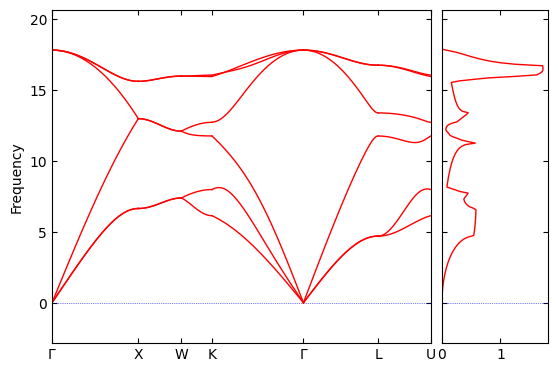

In [13]:
# Here we plot the phonon band structure and density of states
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=101)
phonon_LAMMPS.run_band_structure(qpoints, path_connections=connections, labels=labels)
phonon_LAMMPS.plot_band_structure

# You can auto select k-path using seek path
# phonon.auto_band_structure(plot=True).show()

# To plot DOS next to band structure
# Units of frequency in THz
phonon_LAMMPS.run_mesh([41, 41, 41])
phonon_LAMMPS.run_total_dos()
phonon_LAMMPS.plot_band_structure_and_dos().show()

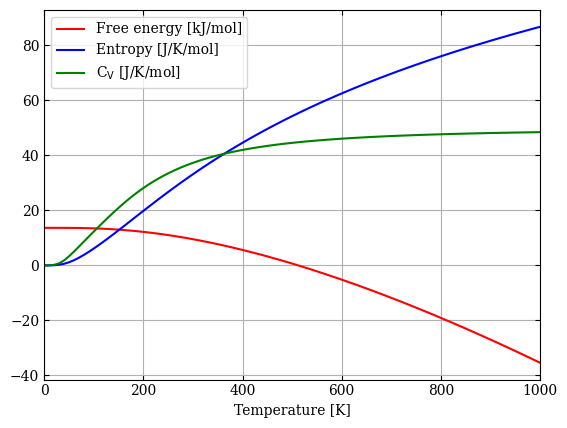

In [14]:
# Thermal properties
phonon_LAMMPS.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
tp_dict = phonon_LAMMPS.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']
phonon_LAMMPS.plot_thermal_properties().show()

In [15]:
freq_LAMMPS, g_omega_LAMMPS = phonon_LAMMPS.get_total_DOS()
phonon_LAMMPS.write_yaml_band_structure(filename="band_LAMMPS.yaml")
!phonopy-bandplot --gnuplot band_LAMMPS.yaml > LAMMPS_BANDS.dat

<ipython-input-15-61ff7e70a0d3>:1: DeprecationWarning: Phonopy.get_total_DOS() is deprecated. Use Phonopy.get_total_dos_dict().
  freq_LAMMPS, g_omega_LAMMPS = phonon_LAMMPS.get_total_DOS()


## Loading VASP force constants

In [16]:
# We load the saved force constants from QE/VASP
# We only used QE/VASP for calculation of the force constants
# hence other things remain the same.
# phonon_QE = phonopy.load("phonopy_params.yaml", force_constants_filename="/content/FORCE_CONSTANTS_QE", factor=PwscfToTHz,is_compact_fc=False)
phonon_VASP = phonopy.load("phonopy_params.yaml", force_constants_filename="/content/FORCE_CONSTANTS_VASP", is_compact_fc=False)

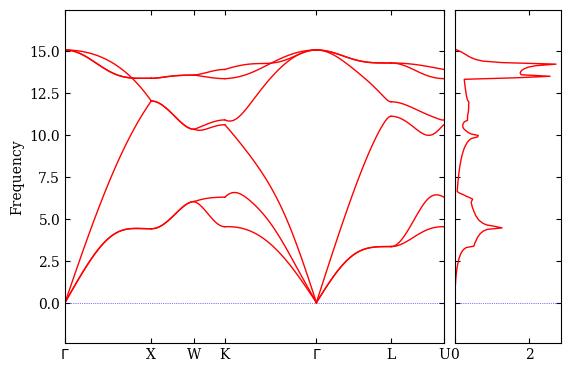

In [17]:
# Here we plot the phonon band structure and density of states
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=101)
phonon_VASP.run_band_structure(qpoints, path_connections=connections, labels=labels)
phonon_VASP.plot_band_structure

# You can auto select k-path using seek path
# phonon.auto_band_structure(plot=True).show()

# To plot DOS next to band structure
# Units of frequency in THz
phonon_VASP.run_mesh([41, 41, 41])
phonon_VASP.run_total_dos()
phonon_VASP.plot_band_structure_and_dos().show()

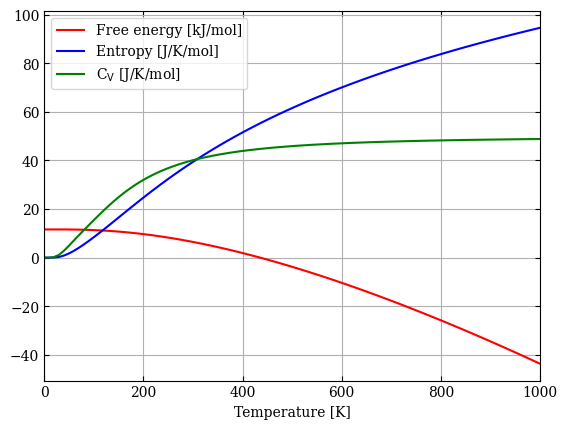

In [18]:
# Thermal properties
phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']
phonon_VASP.plot_thermal_properties().show()

In [19]:
freq_VASP, g_omega_VASP = phonon_VASP.get_total_DOS()
phonon_VASP.write_yaml_band_structure(filename="band_VASP.yaml")
!phonopy-bandplot --gnuplot band_VASP.yaml > VASP_BANDS.dat

<ipython-input-19-89e86666af60>:1: DeprecationWarning: Phonopy.get_total_DOS() is deprecated. Use Phonopy.get_total_dos_dict().
  freq_VASP, g_omega_VASP = phonon_VASP.get_total_DOS()


## LAMMPS comparison

In [20]:
data_AD = pd.read_csv("/content/JAX_BANDS.dat", delimiter=" ", header=2)
data_FD = pd.read_csv("/content/LAMMPS_BANDS.dat", delimiter=" ", header=2)
x_AD, y_AD = data_AD.iloc[:, 0], data_AD.iloc[:, 1]
x_FD, y_FD = data_FD.iloc[:, 0], data_FD.iloc[:, 1]

In [21]:
fig = plt.figure(figsize=(12, 8))

plt.plot([0,max(x_AD)],[0,0],"--",color='b', lw=2)
plt.ylim(-1,20)
plt.xlim(min(x_AD),max(x_AD))
plt.ylim()
plt.ylabel(r"$\omega(q)$ (THz)")
plt.xlabel("Wave vector $q$ (crystal units)")
plot_band_path_lines()
plt.plot(x_AD,y_AD, "o", markersize=6,label="JAX MD AD", color='black')
plt.plot(x_FD,y_FD, "*", markersize=2,label="LAMMPS FD", color='red')
plt.legend()
plt.savefig("band_comp_lammps.png", dpi=300)
plt.close()

In [22]:
data_AD = pd.read_csv("/content/JAX_BANDS.dat", delimiter=" ", header=2)
data_FD = pd.read_csv("/content/LAMMPS_BANDS.dat", delimiter=" ", header=2)
x_AD = data_AD.iloc[:, 0]
y_AD = data_AD.iloc[:, 1]
x_FD = data_FD.iloc[:, 0]
y_FD = data_FD.iloc[:, 1]
fig = plt.figure(figsize=(12, 8))

plt.plot([0,max(x_AD)],[0,0],"--",color='b', lw=2)
plt.ylim(-2,20)
plt.xlim(min(x_AD),max(x_AD))
plt.ylim()
plt.ylabel(r"$\omega(q)$ (THz)")
plt.xlabel("Wave vector $q$ (crystal units)")
plot_band_path_lines()
plt.plot(x_AD,y_AD, "o", markersize=6,label="JAX MD AD", color='black')
plt.plot(x_FD,y_FD, "*", markersize=2,label="LAMMPS FD", color='red')
plt.legend()
plt.savefig("band_comp_lammps_2.png", dpi=300)
plt.close()

In [23]:
fig = plt.figure(figsize=(8, 6))
plt.plot(freq_JAX,g_omega_JAX, lw=4,label="JAX MD AD", color='black')
plt.plot(freq_LAMMPS,g_omega_LAMMPS, lw=1,label="LAMMPS FD", color='red')
plt.xlabel(r"$\omega$ (THz)")
plt.ylabel(r"$g(\omega)$")
plt.legend()
plt.savefig("dos_comp_lammps.png", dpi=300)
plt.close()

## Optimization

In [24]:
# Lattice constant for SW potential
latvec_dia_con = jnp.array([[5.4685816539983962, 0.00000000, 0.000000], [0.00000, 5.4685816539983962, 0.00000], [0.00000, 0.00000, 5.4685816539983962]])

# Positions and lattice vectors
R_con_dia, l_con_dia = pos_lattice(si_text_dia_con, latvec_dia_con, 1)

# Construct super cell with phonopy
unitcell = phonopy.structure.atoms.PhonopyAtoms(symbols=['Si'] * 8,
                        cell=l_con_dia, # Lattice vector
                        scaled_positions=R_con_dia) # Scaled co-ordinates of super-cell

phonon = phonopy.Phonopy(unitcell,
                 supercell_matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                  primitive_matrix=[[0, 0.5, 0.5],
                                   [0.5, 0, 0.5],
                                   [0.5, 0.5, 0]])
phonon.save()

# Generate super cell
R_s, l_s = phonon.supercell.scaled_positions, phonon.supercell.cell
R_s_dia, l_s_dia = jnp.array(R_s, f64), jnp.array(l_s, f64)

In [25]:
def setup(R,latvec):
  displacement, shift = space.periodic_general(latvec)
  dist_fun = space.metric(displacement)

  def hessian_linearized(energy_fn, R, **kwargs):
    U_R = jit(partial(energy_fn, **kwargs))
    _, hvp = linearize(grad(U_R), R)
    hvp = jit(hvp)
    basis = jnp.eye(R.shape[0]*R.shape[1]).reshape(-1, *R.shape)
    return jnp.stack([hvp(e) for e in basis]).reshape(R.shape + R.shape)

  # greif.geo.berkeley.edu/~driver/conversions.html
  # QE force constants (Ry/bohr^2 -> eV/A^2)
  # H_QE = phonon_QE.force_constants.reshape(3*R.shape[0],3*R.shape[0]) * 25.71104309541616 / 0.529177208
  H_VASP = phonon_VASP.force_constants.reshape(3*R.shape[0],3*R.shape[0])

  def run(params):
    energy_fn =  jit(energy.stillinger_weber(displacement,epsilon=params[0],lam=params[1], sigma=2.123822))

    H_CALC = hessian_linearized(energy_fn,R=R)
    # H_CALC = jacrev(jacfwd(energy_fn))(R)
    H_JAX = H_CALC.swapaxes(1,2).reshape(3*R.shape[0],3*R.shape[0])

    return jnp.linalg.norm(H_JAX - H_VASP,ord='fro')
  return run

run = jit(setup(jnp.array(R_s_dia), l_s_dia))

In [26]:
e_m = 2.16826
lam_m = 21.0
params = jnp.array([e_m,lam_m],dtype=f64)
grad_params = jit(jacfwd(run))

In [27]:
# Call the function
run(params)
grad_params(params)

Array([132.0145526 ,   2.03623265], dtype=float64)

In [28]:
# Print callback function
def print3x(params):
    global Nfeval
    global fout
    fout.write('{0:4d},{1:3.12f},{2: 3.12f},{3: 3.12f},{4: 3.12f}'.format(Nfeval,params[0],params[1],run(params),jnp.amax(jnp.abs(grad_params(params)))) + '\n')
    Nfeval += 1

Nfeval = 1
fout = open('CG_steps_c4_og1.dat','w')
fout.write('iter,epsilon,lambda,obj_fun,grad_max \n')
res = scipy_min(run, params, jac=grad_params, method='CG', callback=print3x, options={'disp': True, 'maxiter': 200,  'gtol' : 1e-30} , tol=1e-30)
fout.close()

         Current function value: 14.194132
         Iterations: 21
         Function evaluations: 90
         Gradient evaluations: 79


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


In [29]:
e_m2 = 1.64833
lam_m2 = 31.5
params2 = jnp.array([e_m2,lam_m2],dtype=f64)

Nfeval = 1
fout = open('CG_steps_c4_og2.dat','w')
fout.write('iter,epsilon,lambda,obj_fun,grad_max \n')
res = scipy_min(run, params2, jac=grad_params, method='CG', callback=print3x,options={'disp': True, 'maxiter': 200,  'gtol' : 1e-30} , tol=1e-30)
fout.close()

         Current function value: 14.194132
         Iterations: 23
         Function evaluations: 72
         Gradient evaluations: 71


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


In [30]:
N = 20
e_search = jnp.linspace(1.2,2.25, N)
l_search = jnp.linspace(15,35, N)

Z_search = onp.zeros((N,N))
for i in range(len(e_search)):
  for j in range(len(l_search)):
    params_search = jnp.array([e_search[i],l_search[j]],dtype=f64)
    Z_search[i,j] = run(params_search)

In [31]:
cg_og1_1 = pd.read_csv("/content/CG_steps_c4_og1.dat",delimiter=",")
cg_og2_1 = pd.read_csv("/content/CG_steps_c4_og2.dat",delimiter=",")

cg_og1_2 = pd.DataFrame(onp.insert(cg_og1_1.values, 0, values=[0, e_m, lam_m, run(params), jnp.amax(jnp.abs(grad_params(params)))], axis=0))
cg_og2_2 = pd.DataFrame(onp.insert(cg_og2_1.values, 0, values=[0, e_m2, lam_m2, run(params2), jnp.amax(jnp.abs(grad_params(params2)))], axis=0))

# Define column names of DataFrame
cg_og1_2.columns = cg_og1_1.columns
cg_og2_2.columns = cg_og2_1.columns

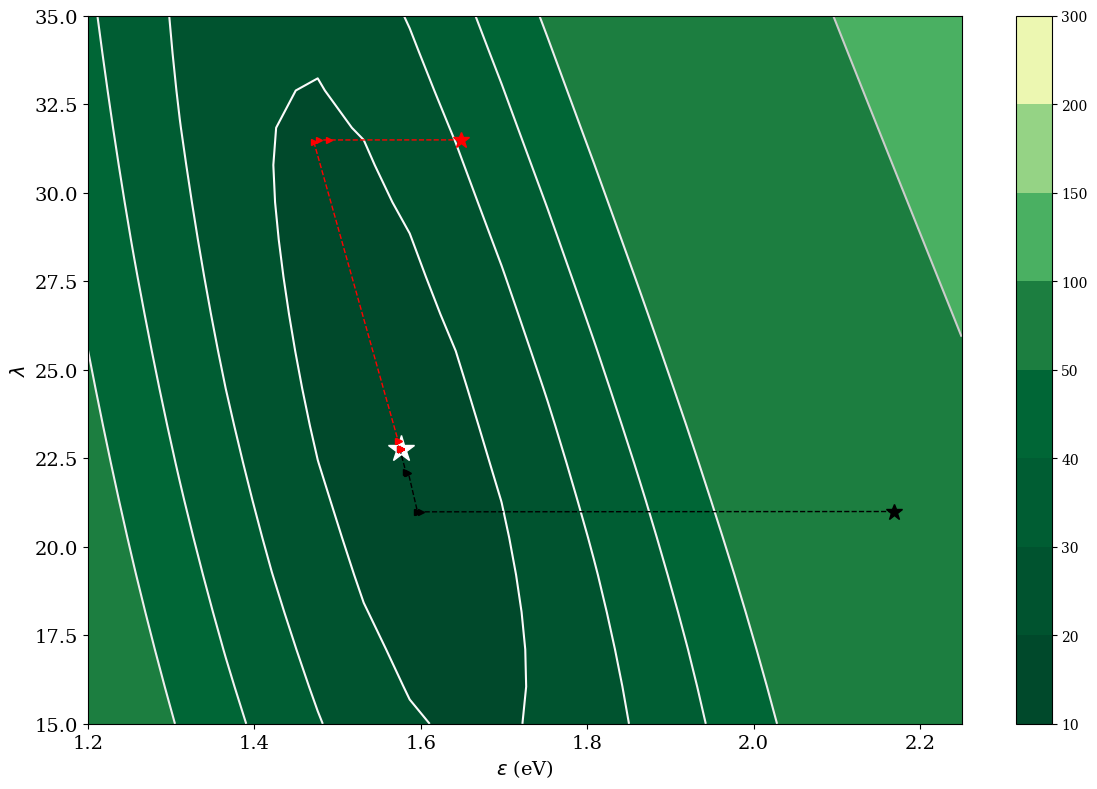

In [32]:
fig = plt.figure(figsize=(12, 8))

X, Y = jnp.meshgrid(e_search, l_search)
# Draw rectangular contour plot
c1 = plt.contourf(X.transpose(), Y.transpose(), Z_search, cmap='YlGn_r',levels=[10,20,30,40,50,100,150,200,300])
c2 = plt.contour(X.transpose(), Y.transpose(), Z_search,levels=[10,20,30,40,50,100,150,200,300], cmap='Greys')
plt.plot(1.576510856061, 22.759370705003,'*',color='white',ms=20)

plt.plot(e_m,lam_m,'*',color='Black',ms=12)
plt.plot(cg_og1_2['epsilon'],cg_og1_2['lambda'],'-->',color='Black',linewidth=1,ms=4)
plt.plot(e_m2,lam_m2,'*',color='Red',ms=12)
plt.plot(cg_og2_2['epsilon'],cg_og2_2['lambda'],'-->',color='Red',linewidth=1,ms=4)

plt.xlabel("$\epsilon$ (eV)",fontsize=14)
plt.ylabel("$\lambda$",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar(c1,extend='both')
plt.tight_layout()
plt.savefig("contour_CG.png",dpi=300)
plt.show()

In [33]:
energy_fn_exact_n = energy.stillinger_weber(displacement_dia, epsilon=1.576510856061, lam=22.759370705003, sigma=2.123822)
energy_fn_exact =  energy.stillinger_weber(displacement_dia, sigma=2.123822)

H_n = hessian_linearized(energy_fn_exact_n,R=jnp.array(R_s_dia))
H_o = hessian_linearized(energy_fn_exact, R=jnp.array(R_s_dia))

In [34]:
H_n_reshaped = H_n.swapaxes(1,2).reshape(3*R_s_dia.shape[0],3*R_s_dia.shape[0])
H_o_reshaped = H_o.swapaxes(1,2).reshape(3*R_s_dia.shape[0],3*R_s_dia.shape[0])

In [35]:
phonon_n = phonon
phonon_n.force_constants = H_n_reshaped
# Here we plot the phonon band structure and density of states
path = [[[0, 0, 0], [1/2, 0, 1/2], [1/2, 1/4, 3/4],
        [3/8, 3/8, 3/4], [0, 0, 0], [1/2, 1/2, 1/2], [5/8, 1/4, 5/8]]]
labels = ["$\\Gamma$", "X", "W", "K", "$\\Gamma$", "L", "U"]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=101)
phonon_n.run_band_structure(qpoints, path_connections=connections, labels=labels)
# You can do select k-path using seek path
# phonon.auto_band_structure(plot=True).show()

# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()

# We write and save the band structure for comparison later
freq_JAX_opt, g_omega_JAX_opt = phonon_n.get_total_DOS()
phonon_n.write_yaml_band_structure()
!phonopy-bandplot --gnuplot band.yaml > JAX_BANDS_opt.dat

<ipython-input-35-0d9a43a06cca>:18: DeprecationWarning: Phonopy.get_total_DOS() is deprecated. Use Phonopy.get_total_dos_dict().
  freq_JAX_opt, g_omega_JAX_opt = phonon_n.get_total_DOS()


## Final comparison

In [36]:
onp.save('freq_JAX_SW', freq_JAX)
onp.save('freq_VASP_SW', freq_VASP)
onp.save('freq_JAX_opt_SW', freq_JAX_opt)
onp.save('freq_LAMMPS_SW', freq_LAMMPS)
onp.save('g_omega_JAX_SW', g_omega_JAX)
onp.save('g_omega_VASP_SW', g_omega_VASP)
onp.save('g_omega_JAX_opt_SW', g_omega_JAX_opt)
onp.save('g_omega_LAMMPS_SW', g_omega_LAMMPS)

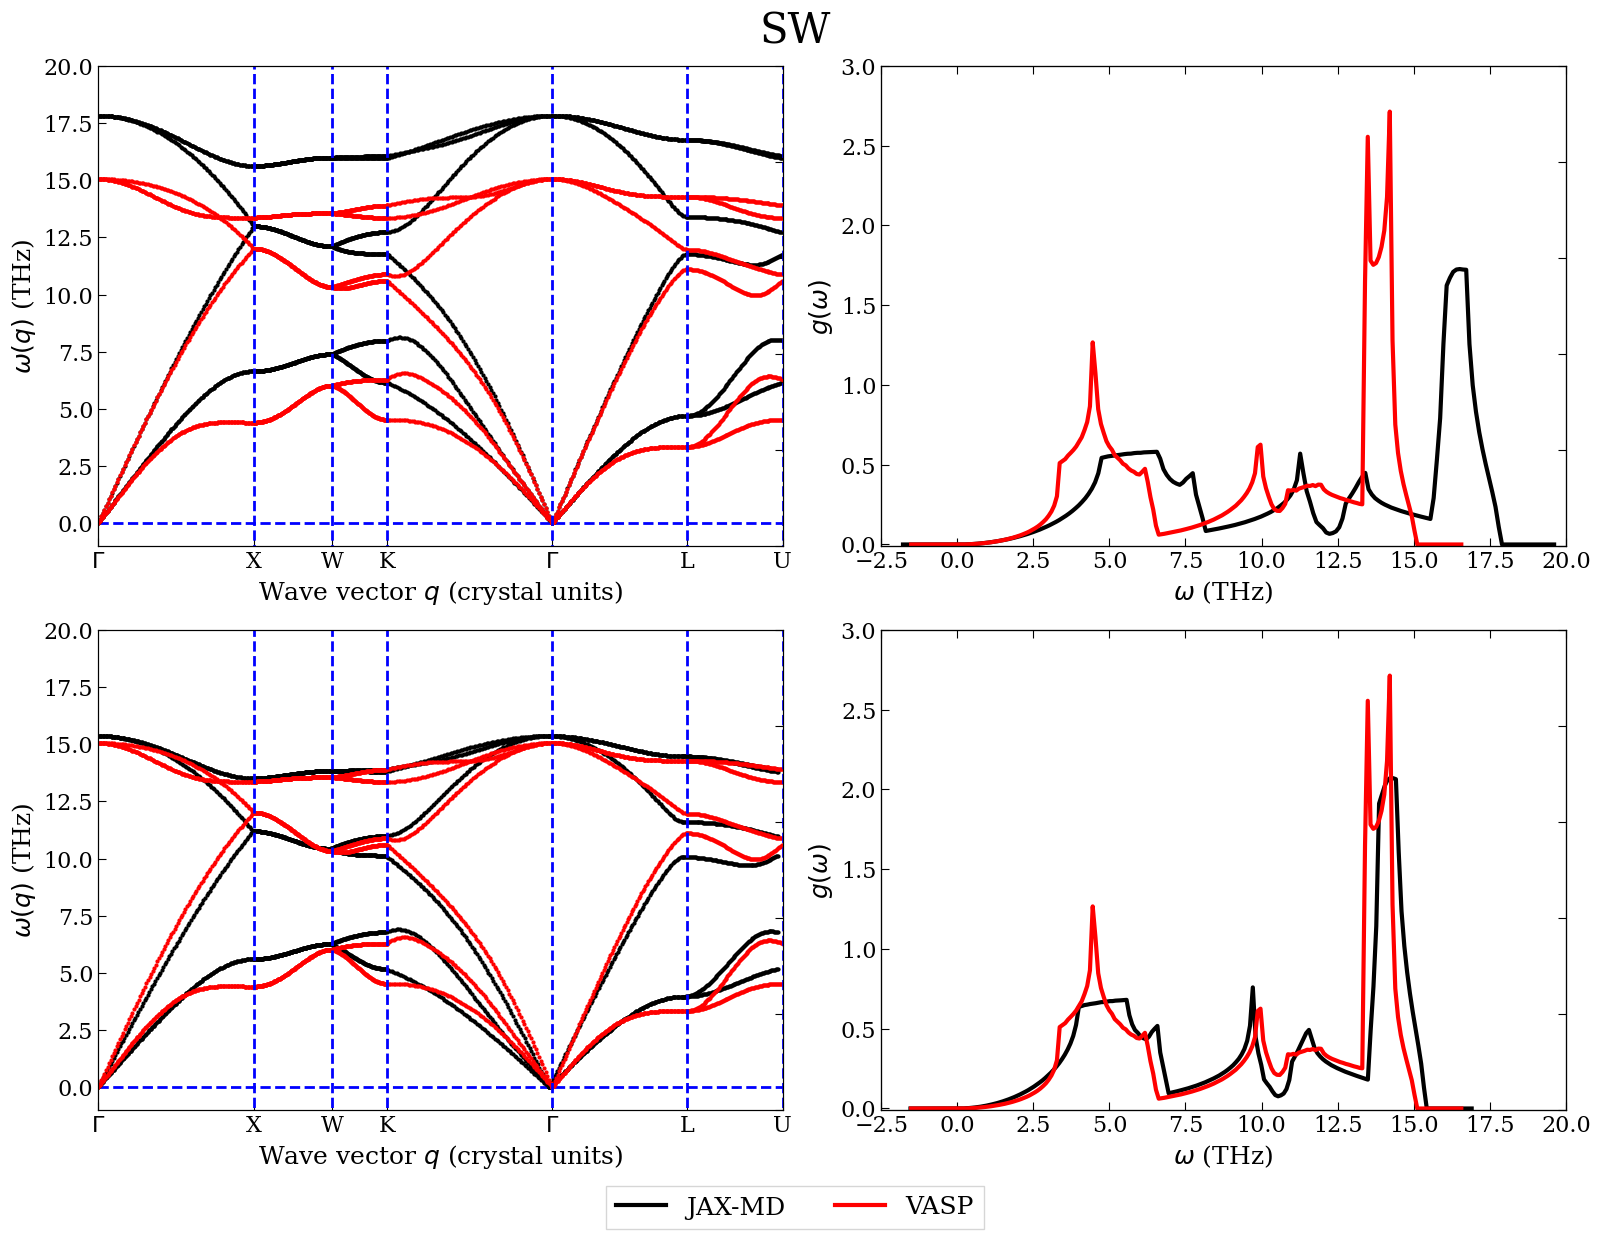

In [37]:
data_AD = pd.read_csv("/content/JAX_BANDS.dat", delimiter=" ", header=2)
data_AD_n = pd.read_csv("/content/JAX_BANDS_opt.dat", delimiter=" ", header=2)
data_VASP = pd.read_csv("/content/VASP_BANDS.dat", delimiter=" ", header=2)
x_AD = data_AD.iloc[:, 0]
y_AD = data_AD.iloc[:, 1]
x_VASP = data_VASP.iloc[:, 0]
y_VASP = data_VASP.iloc[:, 1]
x_AD_n = data_AD_n.iloc[:, 0]
y_AD_n = data_AD_n.iloc[:, 1]

fig, ax1 = plt.subplots(2, 2,figsize=(16, 12))
fig.suptitle('SW', fontsize=30)

ax2 = ax1[0,0].twinx()
ax1[0,0].plot([0,max(x_AD)],[0,0],"--",color='b', lw=2)
ax1[0,0].set_ylim(-1,20)
ax1[0,0].set_xlim(min(x_AD),max(x_AD))
ax1[0,0].set_ylim()
ax1[0,0].set_ylabel(r"$\omega(q)$ (THz)",fontsize=18)
ax1[0,0].set_xlabel("Wave vector $q$ (crystal units)", fontsize=18)
plot_band_path_lines()

ax1[0,0].plot(x_AD,y_AD, "o", markersize=2,label="JAX-MD", color='black')
ax1[0,0].plot(x_VASP,y_VASP, "o", markersize=2,label="VASP", color='red')
ax1[0,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2 = ax1[1,0].twinx()
ax1[1,0].plot([0,max(x_AD)],[0,0],"--",color='b', lw=2)
ax1[1,0].set_ylim(-1,20)
ax1[1,0].set_xlim(min(x_AD),max(x_AD))
ax1[1,0].set_ylim()
ax1[1,0].set_ylabel(r"$\omega(q)$ (THz)",fontsize=18)
ax1[1,0].set_xlabel("Wave vector $q$ (crystal units)", fontsize=18)
plot_band_path_lines()

ax1[1,0].plot(x_AD_n,y_AD_n, "o", markersize=2, color='black', label="JAX-MD")
ax1[1,0].plot(x_VASP,y_VASP, "o", markersize=2, color='red' ,label="VASP")
ax1[1,0].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,0].tick_params(axis="x", direction='in', length=6, labelsize=16)

# handles_p, labels_p = ax1[1].get_legend_handles_labels()
# fig.legend(handles_p, handles_p, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=5)
# fig.legend(handles_p, labels_p, loc='upper center', bbox_to_anchor=(0.5, 0.01), fancybox=False, bbox_transform=fig.transFigure, ncol=5, fontsize=18)

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax2 = ax1[0,1].twinx()
ax3 = ax1[0,1].twiny()
ax1[0,1].set_ylabel(r"$g(\omega)$",fontsize=18)
ax1[0,1].set_xlabel(r"$\omega$ (THz)", fontsize=18)

ax1[0,1].plot(freq_JAX,g_omega_JAX, lw=3,label="JAX-MD", color='black')
ax1[0,1].plot(freq_VASP,g_omega_VASP, lw=3,label="VASP-DFT", color='red')

ax1[0,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[0,1].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax1[0,1].set_ylim(-0.01,3)
ax1[0,1].set_xlim(-2.5,20)

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])

ax3.set_xlim(-2.5,20)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

ax2 = ax1[1,1].twinx()
ax3 = ax1[1,1].twiny()
ax1[1,1].set_ylabel(r"$g(\omega)$",fontsize=18)
ax1[1,1].set_xlabel(r"$\omega$ (THz)", fontsize=18)

ax1[1,1].plot(freq_JAX_opt,g_omega_JAX_opt, lw=3,label="JAX-MD", color='black')
ax1[1,1].plot(freq_VASP,g_omega_VASP, lw=3,label="VASP", color='red')

ax1[1,1].set_ylim(-0.01,3)
ax1[1,1].set_xlim(-2.5,20)
ax1[1,1].tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1[1,1].tick_params(axis="x", direction='in', length=6, labelsize=16)

ax2.tick_params(axis="y", direction='in', length=6)
ax2.set_yticklabels([])
ax3.set_xlim(-2.5,20)
ax3.tick_params(axis="x", direction='in', length=6)
ax3.set_xticklabels([])

handles_p, labels_p = ax1[1,1].get_legend_handles_labels()
fig.legend(handles_p,
           labels_p,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.01),
           fancybox=False,
           bbox_transform=fig.transFigure, ncol=5, fontsize=18)

plt.tight_layout()
plt.savefig("all_comp_final.pdf", dpi=300,  bbox_inches='tight')
plt.show()

In [38]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()

# Saving the dictionary to a file
with open('VASP_thermo_SW.pkl', 'wb') as file:
    pickle.dump(tp_dict, file)

temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, alpha=0.5, lw=4,label="QE-DFT - Free energy")
# plt.plot(temperatures, entropy, alpha=0.5, lw=4,label="QE-DFT - Entropy")
plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="VASP-DFT - heat capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()

# Saving the dictionary to a file
with open('JAX_thermo_SW.pkl', 'wb') as file:
    pickle.dump(tp_dict, file)

temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, lw=2,label="JAX MD (SW original) - Free energy")
# plt.plot(temperatures, entropy, lw=2,label="JAX MD (SW original) - Entropy")
plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()

# Saving the dictionary to a file
with open('JAX_thermo_SW_opt.pkl', 'wb') as file:
    pickle.dump(tp_dict, file)

temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, lw=2,label="AD JAX MD - Free energy")
# plt.plot(temperatures, entropy, lw=2,label="AD JAX MD - Entropy")
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat_capacity", color='black')

plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$C_{v} (J/K mol)$")
# plt.show()
plt.savefig("cv_comp_1.png", dpi=300)
plt.close()

In [39]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, alpha=0.5, lw=4,label="QE-DFT - Free energy")
# plt.plot(temperatures, entropy, alpha=0.5, lw=4,label="QE-DFT - Entropy")
plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="VASP-DFT - heat capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, lw=2,label="JAX MD (SW original) - Free energy")
# plt.plot(temperatures, entropy, lw=2,label="JAX MD (SW original) - Entropy")
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat_capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, lw=2,label="AD JAX MD - Free energy")
# plt.plot(temperatures, entropy, lw=2,label="AD JAX MD - Entropy")
plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat capacity", color='black')

plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$C_{v} (J/K mol)$")
# plt.show()
plt.savefig("cv_comp_2.png", dpi=300)
plt.close()

In [40]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, alpha=1, lw=6,label="QE-DFT - free_energy", color='red')
plt.plot(temperatures, entropy, alpha=1, lw=6,label="VASP-DFT - entropy", color='red')
# plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="QE-DFT - heat_capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW original) - free_energy", color='black')
plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW original) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat_capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW optimized) - free_energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW optimized) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat_capacity", color='black')

plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$S (J/K mol)$")
# plt.show()
plt.savefig("entropy_comp_1.png", dpi=300)
plt.close()

In [41]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, alpha=1, lw=6,label="QE-DFT - free_energy", color='red')
plt.plot(temperatures, entropy, alpha=1, lw=6,label="VASP-DFT - entropy", color='red')
# plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="QE-DFT - heat_capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW original) - free_energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW original) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat_capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW optimized) - free_energy", color='black')
plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW optimized) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat_capacity", color='black')

plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$S (J/K mol)$")
plt.savefig("entropy_comp_2.png", dpi=300)
plt.close()

In [42]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

plt.plot(temperatures, free_energy, alpha=1, lw=6,label="VASP-DFT - free energy", color='red')
# plt.plot(temperatures, entropy, alpha=1, lw=6,label="QE-DFT - entropy", color='red')
# plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="QE-DFT - heat_capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW original) - free energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW original) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat_capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW optimized) - free_energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW optimized) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat_capacity", color='black')

plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$F (kJ/mol)$")
plt.savefig("fe_comp_1.png", dpi=300)
plt.close()

In [43]:
fig = plt.figure(figsize=(8, 6))

phonon_VASP.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_VASP.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

plt.plot(temperatures, free_energy, alpha=1, lw=6,label="VASP-DFT - free energy", color='red')
# plt.plot(temperatures, entropy, alpha=1, lw=6,label="QE-DFT - entropy", color='red')
# plt.plot(temperatures, heat_capacity, alpha=1, lw=6,label="QE-DFT - heat_capacity", color='red')

phonon.force_constants = H_o_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon.run_mesh([41, 41, 41])
phonon.run_total_dos()
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

# plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW original) - free_energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW original) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW original) - heat_capacity", color='black')

phonon_n.force_constants = H_n_reshaped
# To plot DOS next to band structure
# Units of frequency in THz
phonon_n.run_mesh([41, 41, 41])
phonon_n.run_total_dos()
phonon_n.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

tp_dict = phonon_n.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']

plt.plot(temperatures, free_energy, ls ='--', lw=4,label="JAX MD (SW optimized) - free energy", color='black')
# plt.plot(temperatures, entropy, ls ='--', lw=4,label="JAX MD (SW optimized) - entropy", color='black')
# plt.plot(temperatures, heat_capacity, ls ='--', lw=4,label="JAX MD (SW optimized) - heat_capacity", color='black')


plt.legend()
plt.xlabel(r"Temperature (K)")
plt.ylabel(r"$F (kJ/mol)$")
plt.savefig("fe_comp_2.png", dpi=300)
plt.close()

In [44]:
!phonopy-bandplot --gnuplot band.yaml > JAX_BANDS_opt.dat

In [45]:
# !zip -r SW_PHONON.zip /content